In [ ]:
"""
- Dividing the dataset -------------------------------------------------------------------------------------------------------------------
CIFAR100 data was downloaded in https://www.cs.utoronto.ca/~kriz/cifar.html in which I use an already existing function called unpickle(file) to 
extract the nesccary batchfiles containng data, and label in which I'll specific fine” label to grab the 100 different files.

Using this data extract I'll specify the train and test data. Then I'll access only key of b'fine_labels', and b'data' as it will be the data need for
this assignment

The image data of train_x and text_x will converted to pyTorch tensors and reshaped a standard that is require for PyTorch convolutional networks.
'255.0' value normalization for pixel values of rgb. Additonal normalization is applied to scale the pixel value  scaling the range to [-1, 1]

The TensorDataset is created for both training and test data combine image and label tensor together. The random into a training and a validation set.
 80% of the data is kept for training (subtrain_dataset) and the remaining 20% for validation (validation_dataset). Hence the dividing set process.

 - Selecting the model '2c.#'s' -------------------------------------------------------------------------------------------------------------------
 Model experimentation was conducted to determine the desire model within these comment I'll provided top-view explanation of the specific hyperparameters 
 were tested. The range of experimentation was limited in scope but deemed necessary to avoid confusion regarding the new state of the model. Although the
 range was small, it provided the necessary direction to decide on the next set of model experimentation. 
 Determination of these factor were determine by these factors:
      - Values of the training accuracy/loss and validation accuracy/loss and observed the graph
      - Examine the stability, convergence, and level of overfitting/underfitting of the model with the new changes

2c.1
    - Hypertuning experimentation decrasing the out_channels
        - layer4 out_channels=256
        - fc1 out_features=120
    Result validation loss increase and training loss showing a overfitted model

2c.2
     - Adding dropout .2
        - layer1 dropout
        - layer2 dropout
        - layer3 dropout
        - layer4 droput
        - fc1 dropout
        - fc2 dropout
    Result  training process increase .5->1
    Accuracy increase is slightly improve
    - dropout increase 
        - layer1 .4
        - layer2 .4
        - layer3 .5
        - layer4 .4
        - layer5 .4
    Validation loss and training loss closer
    - added dropout
        - fc2 dropout .3
    result validation and traing loss gap closer

2c.4 
    - Adjusting weight_decay and lr
        - Added weight_decay 1e-4
    Result Gap of validation loss is not increasing anymore but lowering

2C.5
    - Adjusting dropout
        - layer1 .3
        - layer2 .3
        - layer3 .4
        - layer4 .3
        - layer5 .3
        -fc1&2 .2
        
    result convergence training loss improve but validation loss is accelerating result overfitting

2C.6
    - Adjusting weight_decay
        - 1e-3
    Result validation loss gap is no longer increasing

2C.7
    -  Adjust lr and dropout
        - layer1 .2
        - layer2 .2
        - layer3 .3
        - layer4 .2
        - layer5 .2
    Result Training loss is greatly improve

2c.8
    - Adding batch normalizaiton 
        -layer1-5 batch introduce
    Result training loss curve is greatly improve as gap with validation loss is improve

2c.9
    -  Adjusting weight_decay
        - 2e-3
    result minimal changes 
        - 4e-3
    result training accracy is slightly decrease
        - 5e-3
    result gap training accracy is slightly decreasing 
        - 7e-3
    result gap increase more
    (keeping weight decay 2e-3)
    
2c.10
    - Adding data argumentaion
        -randomflip
        -randomrotate(20)
    result gap increasing even more both loss/accuracy
    revert

2c.11
    - Adjust lr & weight decay & betas
        - lr 2e-4
    Result training/validation has greatly improve as the gap has gotten closer
        - weight decay 1e-3
    Result convergence validation and training accuracy has improve future 
        - betas (.85,.999) introduce
    not much of an improvement 
        - weight decay 3e-3
    training loss has greatly increase
        - weight decay 2e-3
    training loss imporved keeping this
    
2c.12  Adjusting lr *** Model select show the best result of training/valdiation loss and with test accracy of 51.2%
        - lr 1e-4
    convergence occuring training accracy and validation loss gap is acceptable
************************************************************************************************************************
        - weight decay 3e-3
        unstable results
        - layer5 LeakyReLu
        - fc1 elu()
        - fc2 elu()
        convergence occurs epoch little later
        - batch 32
        unstable graph 
        
"""

In [208]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn, optim
import torch
import torchvision
import torchvision.transforms as transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
50000
[[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]]
(50000, 3072)
19
(3, 32, 32)
(32, 32, 3)


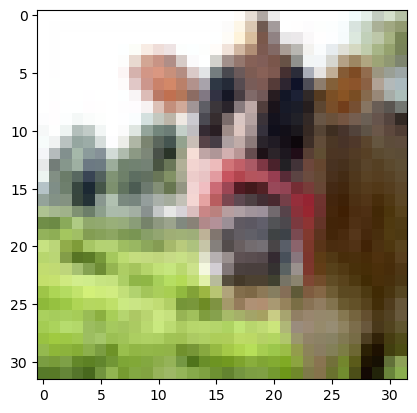

In [209]:
#find path to the folder
file_path = "C:/Users/Johnn/OneDrive/Documents/CNN/Models"
data_dir = 'C:/Users/Johnn/OneDrive/Documents/CNN/Models/cifar-100-python'


# Function to load a file from the dataset
def unpickle(file_path):
    with open(file_path, 'rb') as file:
        dict  = pickle.load(file, encoding='bytes')
    return dict

# Load the training and test data
train_data = unpickle(f'{data_dir}/train')
test_data = unpickle(f'{data_dir}/test')

print(train_data.keys())
# fine labels identify the class of the image
print(len(train_data[b'fine_labels']))
# Will access the data values
print(train_data[b'data'])
print(train_data[b'data'].shape)

# visualize the cifar-100 image by reshaping
image = train_data[b'data'][0]
lab = train_data[b'fine_labels'][0]
# divide 3 channels represents into rgb by 32x32 matrixs 
image = image.reshape(3, 32, 32)
print(lab)
print(image.shape)
# transpose it to 32 x 32 x 3 
image = image.transpose(1, 2, 0)
print(image.shape)
plt.imshow(image)

In [210]:
# Split the training data into a training and a validation set
# Accessing the fine_labels from dic will ensure that the model will predict 100 Classes rather than the super-classes
# train_x raw pixel data for the images, train_y class identifiers you that it needs to predict
train_x, train_y = train_data[b'data'], train_data[b'fine_labels']
test_x, test_y = test_data[b'data'], test_data[b'fine_labels']
# ensure that the images and specific classes match same length
print(f'Train data: {len(train_x)} , Validation data: {len(train_y)}')
print(f'{type(train_x)}, {type(train_y)}')
# convert to tensors
train_x = torch.tensor(train_x, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
train_y = torch.tensor(train_y, dtype=torch.long)
test_x = torch.tensor(test_x, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
test_y = torch.tensor(test_y, dtype=torch.long)
print(train_x.shape)

# Normalize the tensors using the given mean and std
mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std


dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)


train_size = int(0.8 * len(dataset))
# Next is to split the dataset into training 4/5 and validation sets 1/5
subtrain_dataset, validation_dataset = random_split(dataset, [train_size, (len(dataset) - train_size)])
print(f'train: {len(subtrain_dataset)}, val:{len(validation_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train data: 50000 , Validation data: 50000
<class 'numpy.ndarray'>, <class 'list'>
torch.Size([50000, 3, 32, 32])
train: 40000, val:10000


In [211]:
batch_size = 64
num_epochs = 100

## 2c.1 Experminentation on channel sizes model for Alex

In [240]:
def train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs):
    # Create data loaders for the training and validation sets
    subtrain_loader = DataLoader(subtrain_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    tr_acc, tr_loss = [], []
    
    val_acc, val_loss = [], []
    best_val_loss = float('inf')
    early_stop = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in subtrain_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Calculate predictions for train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_accuracy = correct_train / total_train
        tr_acc.append(train_accuracy)
        train_loss = running_loss / len(subtrain_loader)
        tr_loss.append(train_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
        # Validation loop
        model.eval()
        validation_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        validation_loss /= len(validation_loader)
        val_loss.append(validation_loss)
        validation_accuracy =  correct / total
        val_acc.append(validation_accuracy)

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model.state_dict(), 'AlexNetmodel_best_parameters.pth')
            early_stop = 0
        else:
            early_stop += 1
            if early_stop >= 10:
                print(f'Early stopping on epoch {epoch}/{num_epochs}')
                torch.save(model.state_dict(), 'AlexNetmodel_latest_parameters.pth')
                break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')  
    print('Training Completed')
    return tr_acc, tr_loss, val_acc, val_loss



def test_model(model,test_loader):
    #model = model.to(device)
    model.eval()

    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * (correct / total)
    print(f'Test Accuracy: {test_accuracy:.4f}%')
    

def plot_model(tr_acc, tr_loss, val_acc, val_loss):
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [36]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [37]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [38]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 1.5586, Training Accuracy: 0.5589
Epoch 9/100, Validation Loss: 2.3684, Validation Accuracy: 0.4084
Early stopping on epoch 18/100
Training Completed


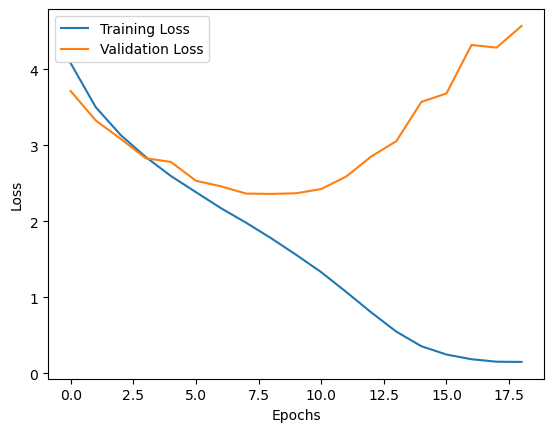

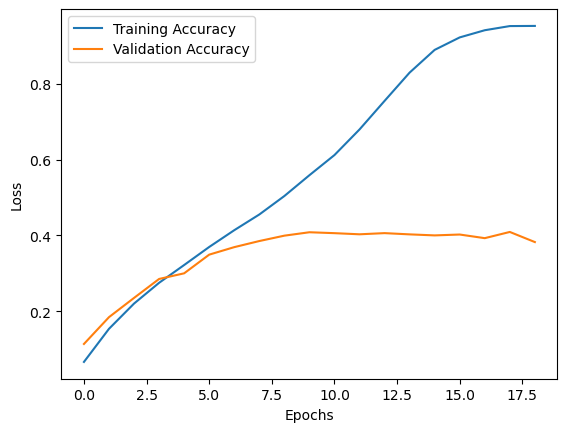

In [39]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [96]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), 
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1), 
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1), 
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # reduce 384->256
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [97]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [98]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 1.6132, Training Accuracy: 0.5439
Epoch 9/100, Validation Loss: 2.4086, Validation Accuracy: 0.3933
Epoch 19/100, Training Loss: 0.1267, Training Accuracy: 0.9619
Epoch 19/100, Validation Loss: 4.7711, Validation Accuracy: 0.3843
Epoch 29/100, Training Loss: 0.0715, Training Accuracy: 0.9800
Early stopping on epoch 29/100
Training Completed


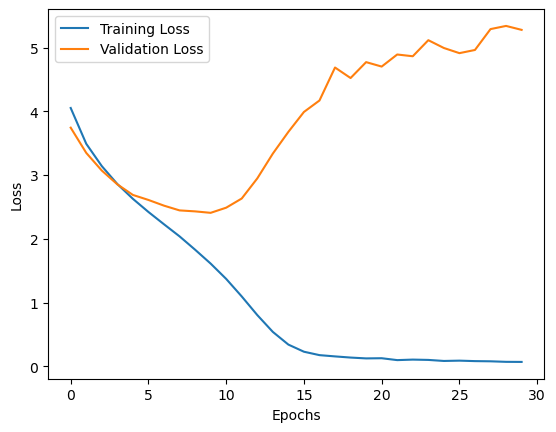

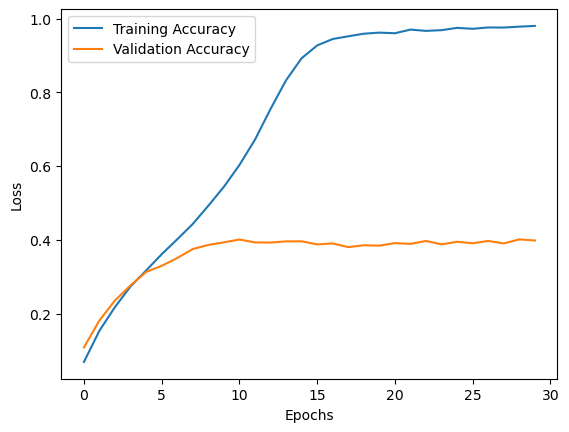

In [99]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [100]:
test_model(model, test_loader)

Test Accuracy: 40.6200%


In [276]:
# Training accracy improve but overfitted

## 2c.2 Experminentation on Dropout values

In [118]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [115]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.2),

            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2),

            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [119]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.5206, Training Accuracy: 0.3438
Epoch 9/100, Validation Loss: 2.5703, Validation Accuracy: 0.3438
Epoch 19/100, Training Loss: 1.4386, Training Accuracy: 0.5841
Epoch 19/100, Validation Loss: 2.4237, Validation Accuracy: 0.4230
Epoch 29/100, Training Loss: 0.4923, Training Accuracy: 0.8472
Epoch 29/100, Validation Loss: 3.2417, Validation Accuracy: 0.4160
Early stopping on epoch 34/100
Training Completed


In [277]:
# Added dropout has improve the gap but need more details to go on

In [122]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.3), # .2->.3
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.4), #.3->.4

            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.4), #.3->.4

            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.3), #.2->.3
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [123]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [124]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.9046, Training Accuracy: 0.2699
Epoch 9/100, Validation Loss: 2.7832, Validation Accuracy: 0.3000
Epoch 19/100, Training Loss: 2.1554, Training Accuracy: 0.4215
Epoch 19/100, Validation Loss: 2.3824, Validation Accuracy: 0.3922
Epoch 29/100, Training Loss: 1.3563, Training Accuracy: 0.6026
Epoch 29/100, Validation Loss: 2.4952, Validation Accuracy: 0.4080
Epoch 39/100, Training Loss: 0.6676, Training Accuracy: 0.7942
Epoch 39/100, Validation Loss: 3.2648, Validation Accuracy: 0.4000
Early stopping on epoch 41/100
Training Completed


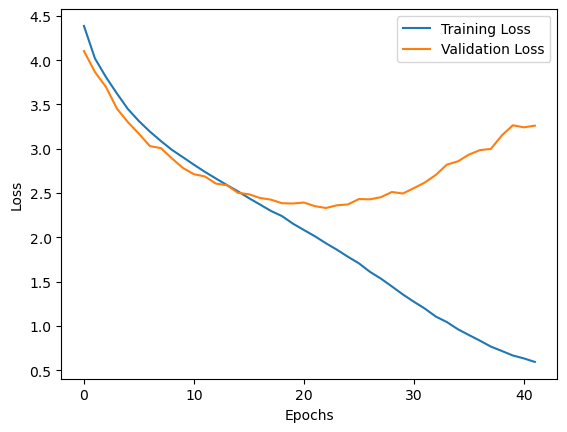

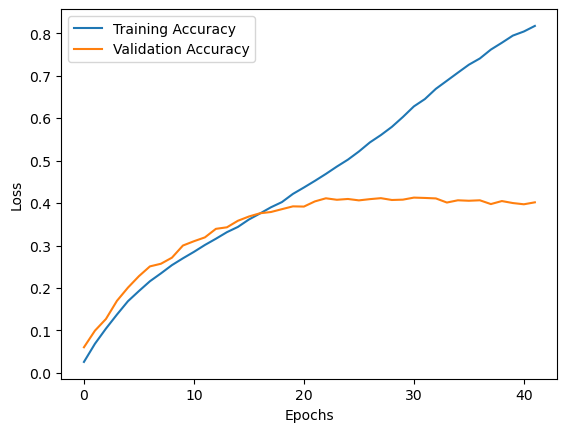

In [125]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [278]:
# Convergence has improve but training has suffer

In [126]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.5), #.4->.5

            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.4), #.3->.4

            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.4), #.2->.4
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [127]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [128]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.1177, Training Accuracy: 0.2307
Epoch 9/100, Validation Loss: 3.0368, Validation Accuracy: 0.2455
Epoch 19/100, Training Loss: 2.4837, Training Accuracy: 0.3503
Epoch 19/100, Validation Loss: 2.6286, Validation Accuracy: 0.3411
Epoch 29/100, Training Loss: 1.7921, Training Accuracy: 0.4995
Epoch 29/100, Validation Loss: 2.5862, Validation Accuracy: 0.3797
Epoch 39/100, Training Loss: 1.0757, Training Accuracy: 0.6771
Epoch 39/100, Validation Loss: 3.0514, Validation Accuracy: 0.3748
Early stopping on epoch 43/100
Training Completed


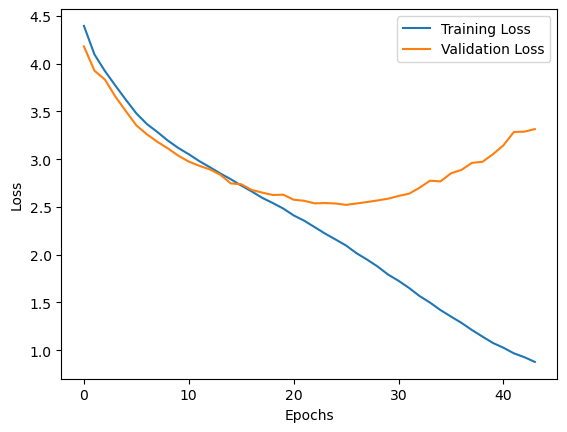

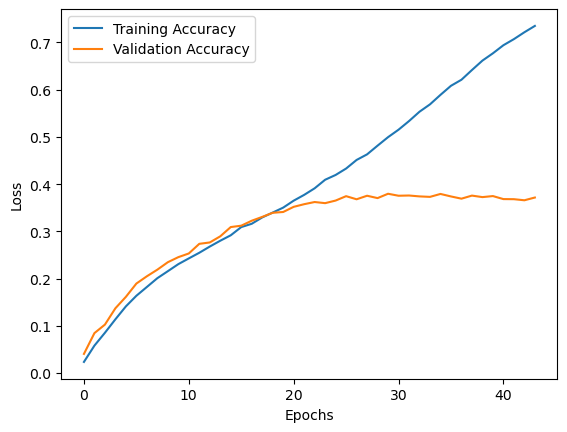

In [129]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [279]:
# Not much change just training loss increase

In [137]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 10/2 = 5
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.5),

            # 10/2 = 5
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.4),

            # 10/2 = 5
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.3), #.2->.3
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.Dropout1d(0.3), #added
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [131]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [132]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.1888, Training Accuracy: 0.2178
Epoch 9/100, Validation Loss: 3.0501, Validation Accuracy: 0.2507
Epoch 19/100, Training Loss: 2.6251, Training Accuracy: 0.3257
Epoch 19/100, Validation Loss: 2.5923, Validation Accuracy: 0.3432
Epoch 29/100, Training Loss: 2.1675, Training Accuracy: 0.4175
Epoch 29/100, Validation Loss: 2.4242, Validation Accuracy: 0.3915
Epoch 39/100, Training Loss: 1.6849, Training Accuracy: 0.5245
Epoch 39/100, Validation Loss: 2.4634, Validation Accuracy: 0.4048
Epoch 49/100, Training Loss: 1.2626, Training Accuracy: 0.6283
Early stopping on epoch 49/100
Training Completed


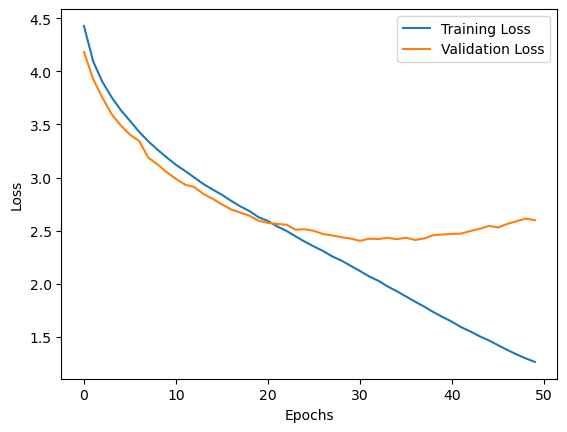

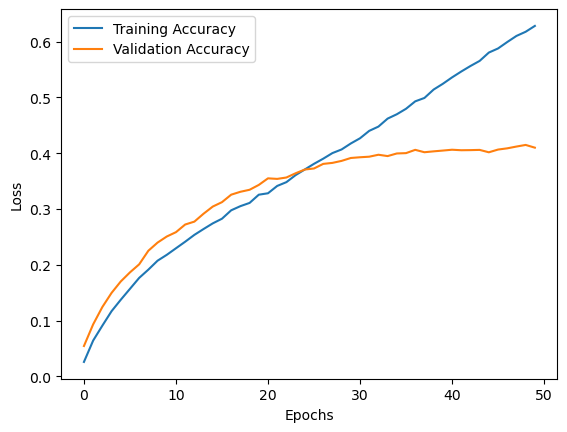

In [134]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [133]:
test_model(model, test_loader)

Test Accuracy: 41.6600%


In [ ]:
# Overfitting occur regardless of limits of batchdrop > .5. May introduce the need weight decay to hopefully improve the need
# of addressing the issue.

## 2c.4 Examine weight decay pramater and tinkering with learning rate

In [139]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# added weight decay helpfully improve overfitting situation
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-4) # added weight decay

In [140]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 4.0986, Training Accuracy: 0.0747
Epoch 9/100, Validation Loss: 3.7779, Validation Accuracy: 0.1633
Epoch 19/100, Training Loss: 3.8770, Training Accuracy: 0.1184
Epoch 19/100, Validation Loss: 3.3759, Validation Accuracy: 0.2406
Epoch 29/100, Training Loss: 3.7273, Training Accuracy: 0.1467
Epoch 29/100, Validation Loss: 3.1480, Validation Accuracy: 0.3066
Epoch 39/100, Training Loss: 3.5803, Training Accuracy: 0.1757
Epoch 39/100, Validation Loss: 2.9670, Validation Accuracy: 0.3392
Epoch 49/100, Training Loss: 3.4240, Training Accuracy: 0.2051
Epoch 49/100, Validation Loss: 2.7968, Validation Accuracy: 0.3609
Epoch 59/100, Training Loss: 3.2294, Training Accuracy: 0.2497
Epoch 59/100, Validation Loss: 2.6654, Validation Accuracy: 0.3777
Epoch 69/100, Training Loss: 3.0458, Training Accuracy: 0.2947
Epoch 69/100, Validation Loss: 2.6507, Validation Accuracy: 0.3684
Early stopping on epoch 77/100
Training Completed


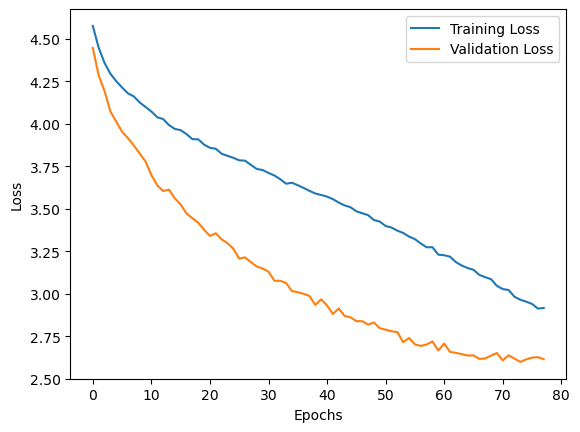

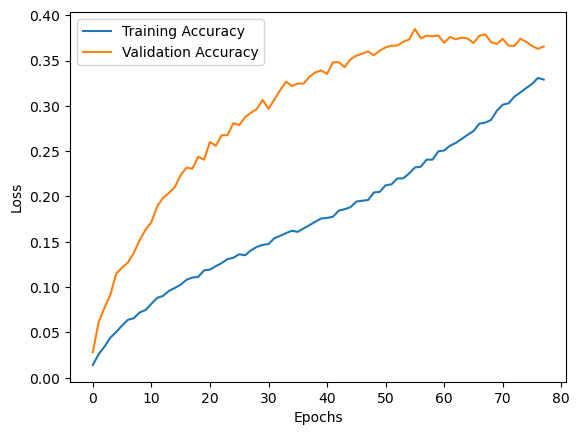

In [141]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [280]:
# No improvement

In [144]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4) #le-4->le-3

In [145]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 4.4264, Training Accuracy: 0.0247
Epoch 9/100, Validation Loss: 4.3460, Validation Accuracy: 0.0444
Epoch 19/100, Training Loss: 4.3279, Training Accuracy: 0.0370
Epoch 19/100, Validation Loss: 4.1858, Validation Accuracy: 0.0678
Epoch 29/100, Training Loss: 4.2659, Training Accuracy: 0.0485
Epoch 29/100, Validation Loss: 4.0880, Validation Accuracy: 0.0892
Epoch 39/100, Training Loss: 4.2303, Training Accuracy: 0.0554
Epoch 39/100, Validation Loss: 3.9987, Validation Accuracy: 0.1090


KeyboardInterrupt: 

In [ ]:
# Adjusting the lr magntiude indicate a slower training rate, thus
# May begin to readjust the dropout rates as it was quite high

## 2c.5 Adjusting dropout lowering

In [146]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.3), # .4 -> .3
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.3), # .4 -> .3
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.4), # .5 -> .4

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.3),# .4 -> .3
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.3), # .4 -> .3
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [ ]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# added weight decay helpfully improve overfitting situation
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-4)

In [148]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.6836, Training Accuracy: 0.1436
Epoch 9/100, Validation Loss: 3.2363, Validation Accuracy: 0.2413
Epoch 19/100, Training Loss: 3.3263, Training Accuracy: 0.2112
Epoch 19/100, Validation Loss: 2.7569, Validation Accuracy: 0.3305
Epoch 29/100, Training Loss: 3.0109, Training Accuracy: 0.2786
Epoch 29/100, Validation Loss: 2.4949, Validation Accuracy: 0.3818
Epoch 39/100, Training Loss: 2.6391, Training Accuracy: 0.3655
Epoch 39/100, Validation Loss: 2.3807, Validation Accuracy: 0.4067
Epoch 49/100, Training Loss: 2.2581, Training Accuracy: 0.4652
Epoch 49/100, Validation Loss: 2.4960, Validation Accuracy: 0.3988
Early stopping on epoch 57/100
Training Completed


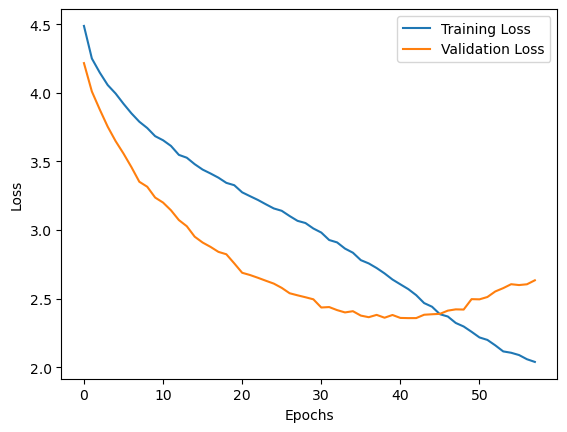

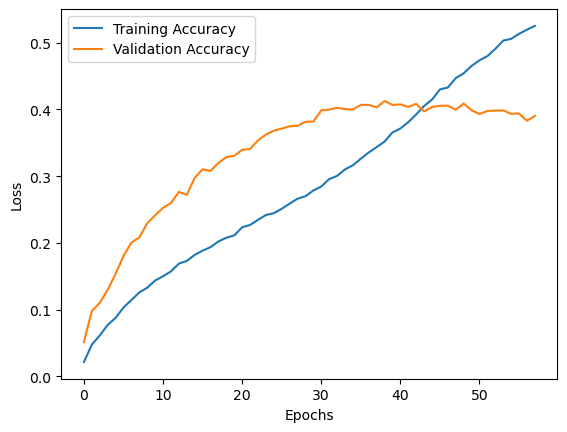

In [149]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# validation loss is increase once more 
# may need to relook at the weight decay once more to resolve this.
# Nonetheless, the improvement on the loss rate is decreasing faster rate so dropout may be left for now 

## 2c.6 Adjusting weight decay

In [150]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# added weight decay helpfully improve overfitting situation
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-3) #le-4->le-3

In [151]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.8857, Training Accuracy: 0.1021
Epoch 9/100, Validation Loss: 3.5136, Validation Accuracy: 0.1645
Epoch 19/100, Training Loss: 3.6126, Training Accuracy: 0.1544
Epoch 19/100, Validation Loss: 3.1545, Validation Accuracy: 0.2641
Epoch 29/100, Training Loss: 3.4275, Training Accuracy: 0.1902
Epoch 29/100, Validation Loss: 2.8464, Validation Accuracy: 0.3174
Epoch 39/100, Training Loss: 3.2814, Training Accuracy: 0.2226
Epoch 39/100, Validation Loss: 2.6373, Validation Accuracy: 0.3650
Epoch 49/100, Training Loss: 3.1495, Training Accuracy: 0.2500
Epoch 49/100, Validation Loss: 2.5078, Validation Accuracy: 0.4070
Epoch 59/100, Training Loss: 3.0472, Training Accuracy: 0.2725
Epoch 59/100, Validation Loss: 2.3463, Validation Accuracy: 0.4237
Early stopping on epoch 67/100
Training Completed


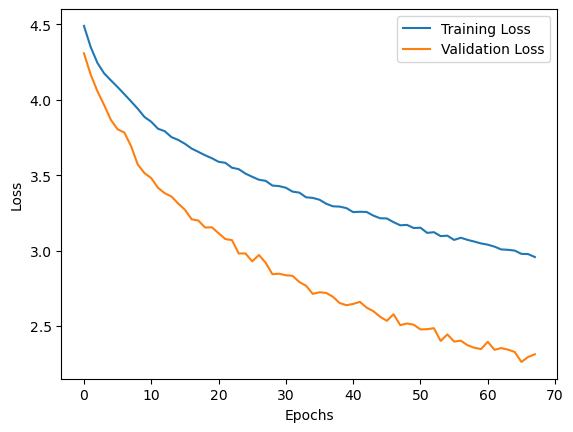

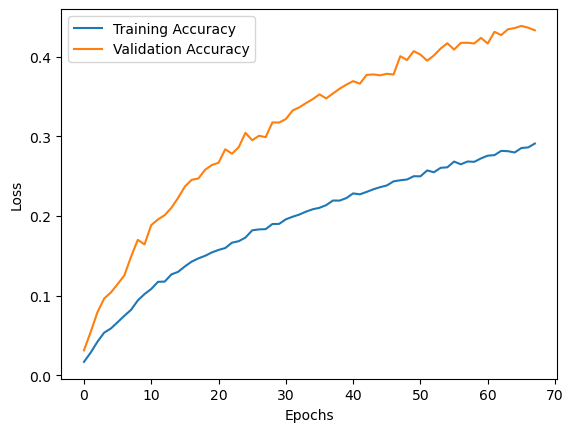

In [152]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [153]:
test_model(model, test_loader)

Test Accuracy: 42.8600%


In [ ]:
# convergence gone underfitting

## 2c.7 adjust lr and dropout

In [154]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), # .4 -> .3

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2),# .3 -> .2
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [155]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-3)

In [156]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.8258, Training Accuracy: 0.1139
Epoch 9/100, Validation Loss: 3.4416, Validation Accuracy: 0.1797
Epoch 19/100, Training Loss: 3.4894, Training Accuracy: 0.1771
Epoch 19/100, Validation Loss: 2.9453, Validation Accuracy: 0.3034
Epoch 29/100, Training Loss: 3.2833, Training Accuracy: 0.2185
Epoch 29/100, Validation Loss: 2.6789, Validation Accuracy: 0.3469
Epoch 39/100, Training Loss: 3.1212, Training Accuracy: 0.2538
Epoch 39/100, Validation Loss: 2.4421, Validation Accuracy: 0.4012
Epoch 49/100, Training Loss: 2.9979, Training Accuracy: 0.2814
Epoch 49/100, Validation Loss: 2.3342, Validation Accuracy: 0.4306
Epoch 59/100, Training Loss: 2.9058, Training Accuracy: 0.3016
Epoch 59/100, Validation Loss: 2.1931, Validation Accuracy: 0.4557
Epoch 69/100, Training Loss: 2.7995, Training Accuracy: 0.3268
Epoch 69/100, Validation Loss: 2.1236, Validation Accuracy: 0.4749
Early stopping on epoch 77/100
Training Completed


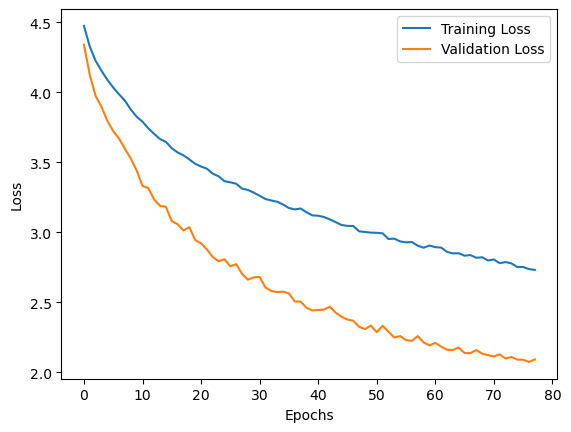

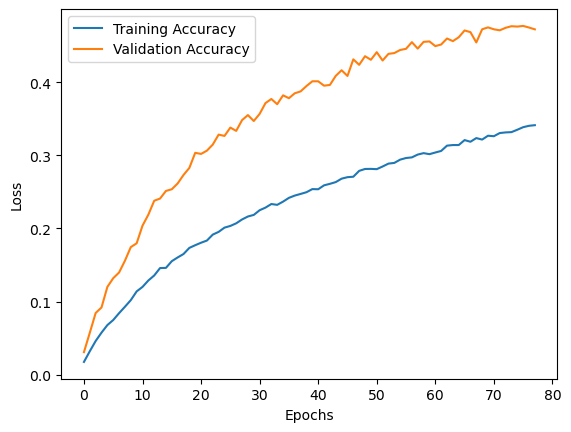

In [157]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [281]:
# improve training loss

## 2c.8 Adding batch normalization

In [167]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), # .4 -> .3

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2),# .3 -> .2
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
          # ((16 − 5 + 2(0))/1)+1=    16x16  384
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100)  # CIFAR-100 has 100 classes
 
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [168]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-3)

In [169]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.2007, Training Accuracy: 0.2396
Epoch 9/100, Validation Loss: 2.4771, Validation Accuracy: 0.4027
Epoch 19/100, Training Loss: 2.8114, Training Accuracy: 0.3268
Epoch 19/100, Validation Loss: 2.1074, Validation Accuracy: 0.4698
Epoch 29/100, Training Loss: 2.5654, Training Accuracy: 0.3859
Epoch 29/100, Validation Loss: 1.9179, Validation Accuracy: 0.5066
Epoch 39/100, Training Loss: 2.3681, Training Accuracy: 0.4370
Epoch 39/100, Validation Loss: 1.8053, Validation Accuracy: 0.5261
Epoch 49/100, Training Loss: 2.2228, Training Accuracy: 0.4736
Epoch 49/100, Validation Loss: 1.7757, Validation Accuracy: 0.5372
Epoch 59/100, Training Loss: 2.1129, Training Accuracy: 0.5060
Epoch 59/100, Validation Loss: 1.7534, Validation Accuracy: 0.5317
Epoch 69/100, Training Loss: 2.0305, Training Accuracy: 0.5284
Epoch 69/100, Validation Loss: 1.7897, Validation Accuracy: 0.5357
Epoch 79/100, Training Loss: 1.9734, Training Accuracy: 0.5465
Epoch 79/100, Validation Loss

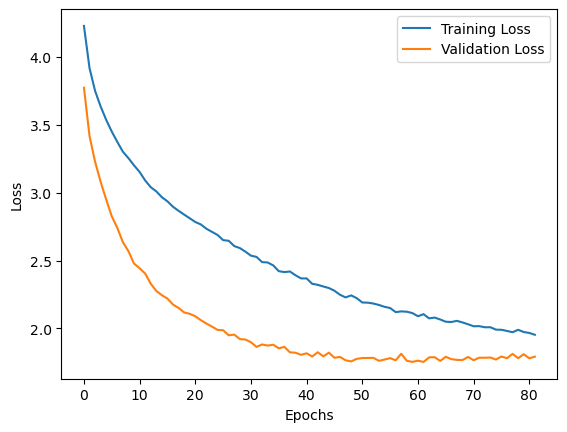

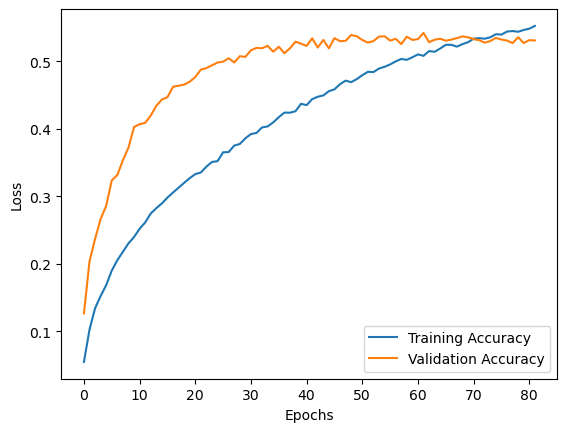

In [170]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# gap between traing loss and valiadtion graph is improve and accuracy as well

## 2c.9 Adjusting the Weight decay

In [174]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3)  #1e-3->2e-3

In [175]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.2524, Training Accuracy: 0.2271
Epoch 9/100, Validation Loss: 2.5565, Validation Accuracy: 0.3723
Epoch 19/100, Training Loss: 2.9391, Training Accuracy: 0.2954
Epoch 19/100, Validation Loss: 2.2206, Validation Accuracy: 0.4457
Epoch 29/100, Training Loss: 2.7340, Training Accuracy: 0.3392
Epoch 29/100, Validation Loss: 2.0313, Validation Accuracy: 0.4958
Epoch 39/100, Training Loss: 2.5623, Training Accuracy: 0.3835
Epoch 39/100, Validation Loss: 1.9251, Validation Accuracy: 0.5121
Epoch 49/100, Training Loss: 2.4256, Training Accuracy: 0.4183
Epoch 49/100, Validation Loss: 1.8662, Validation Accuracy: 0.5067
Epoch 59/100, Training Loss: 2.2918, Training Accuracy: 0.4538
Epoch 59/100, Validation Loss: 1.8196, Validation Accuracy: 0.5254
Epoch 69/100, Training Loss: 2.1754, Training Accuracy: 0.4853
Epoch 69/100, Validation Loss: 1.8326, Validation Accuracy: 0.5184
Epoch 79/100, Training Loss: 2.1100, Training Accuracy: 0.5066
Epoch 79/100, Validation Loss

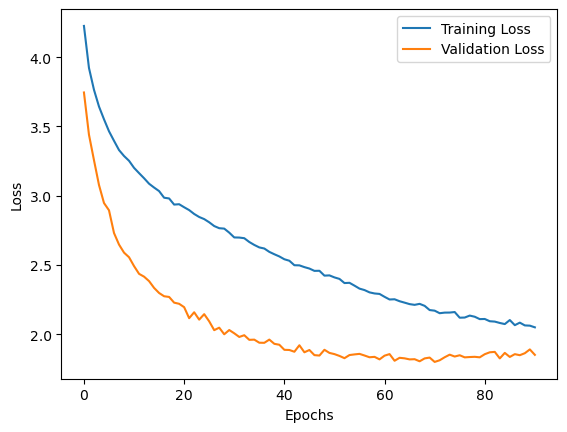

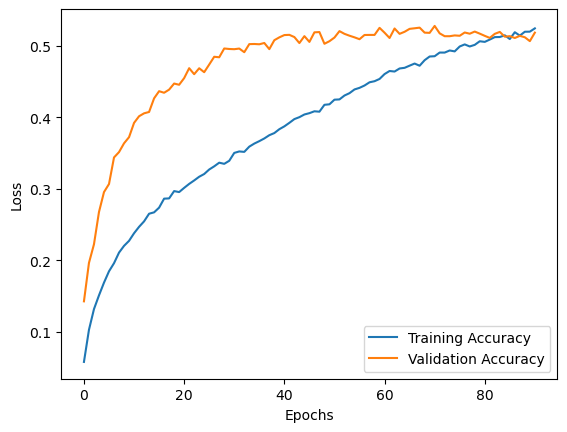

In [176]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [177]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=4e-3) #2e-3->4e-3

In [178]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.3345, Training Accuracy: 0.2084
Epoch 9/100, Validation Loss: 2.6658, Validation Accuracy: 0.3577
Epoch 19/100, Training Loss: 3.0729, Training Accuracy: 0.2647
Epoch 19/100, Validation Loss: 2.3747, Validation Accuracy: 0.4271
Epoch 29/100, Training Loss: 2.8862, Training Accuracy: 0.3075
Epoch 29/100, Validation Loss: 2.1679, Validation Accuracy: 0.4622
Epoch 39/100, Training Loss: 2.7310, Training Accuracy: 0.3420
Epoch 39/100, Validation Loss: 2.0554, Validation Accuracy: 0.4838
Epoch 49/100, Training Loss: 2.6214, Training Accuracy: 0.3714
Epoch 49/100, Validation Loss: 2.0295, Validation Accuracy: 0.4892
Epoch 59/100, Training Loss: 2.4953, Training Accuracy: 0.4024
Epoch 59/100, Validation Loss: 1.9404, Validation Accuracy: 0.4991
Epoch 69/100, Training Loss: 2.3822, Training Accuracy: 0.4316
Epoch 69/100, Validation Loss: 1.9036, Validation Accuracy: 0.5065
Epoch 79/100, Training Loss: 2.3066, Training Accuracy: 0.4490
Epoch 79/100, Validation Loss

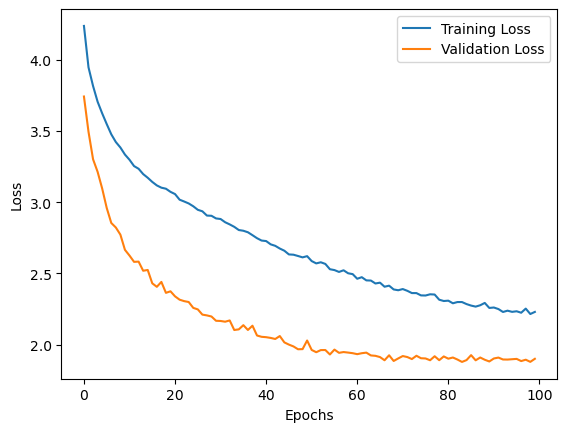

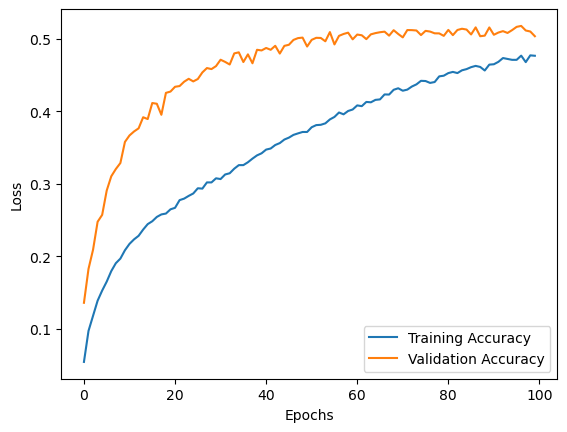

In [179]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [181]:
test_model(model, test_loader)

Test Accuracy: 50.6700%


In [183]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=5e-3) #4e-3->5e-3

In [184]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.3631, Training Accuracy: 0.2016
Epoch 9/200, Validation Loss: 2.7313, Validation Accuracy: 0.3363
Epoch 19/200, Training Loss: 3.1070, Training Accuracy: 0.2567
Epoch 19/200, Validation Loss: 2.4188, Validation Accuracy: 0.4123
Epoch 29/200, Training Loss: 2.9386, Training Accuracy: 0.2919
Epoch 29/200, Validation Loss: 2.2277, Validation Accuracy: 0.4506
Epoch 39/200, Training Loss: 2.8101, Training Accuracy: 0.3236
Epoch 39/200, Validation Loss: 2.1208, Validation Accuracy: 0.4760
Epoch 49/200, Training Loss: 2.6640, Training Accuracy: 0.3575
Epoch 49/200, Validation Loss: 2.0292, Validation Accuracy: 0.4975
Epoch 59/200, Training Loss: 2.5715, Training Accuracy: 0.3819
Epoch 59/200, Validation Loss: 1.9734, Validation Accuracy: 0.5006
Epoch 69/200, Training Loss: 2.4733, Training Accuracy: 0.4061
Epoch 69/200, Validation Loss: 1.9506, Validation Accuracy: 0.5068
Epoch 79/200, Training Loss: 2.4072, Training Accuracy: 0.4248
Epoch 79/200, Validation Loss

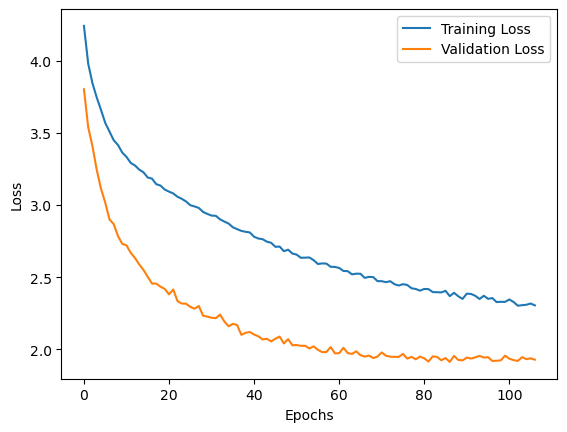

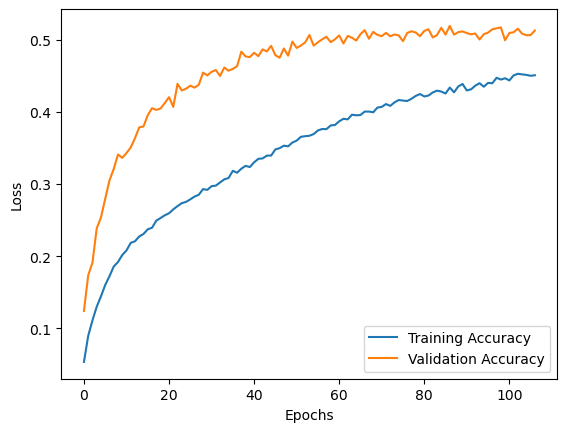

In [185]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# gap increasing

In [186]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=7e-3) #5e-3->7e-3

In [187]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.4335, Training Accuracy: 0.1872
Epoch 9/200, Validation Loss: 2.8341, Validation Accuracy: 0.3191
Epoch 19/200, Training Loss: 3.1843, Training Accuracy: 0.2397
Epoch 19/200, Validation Loss: 2.5280, Validation Accuracy: 0.3802
Epoch 29/200, Training Loss: 3.0374, Training Accuracy: 0.2717
Epoch 29/200, Validation Loss: 2.3845, Validation Accuracy: 0.4155
Epoch 39/200, Training Loss: 2.9026, Training Accuracy: 0.3019
Epoch 39/200, Validation Loss: 2.2501, Validation Accuracy: 0.4481
Epoch 49/200, Training Loss: 2.8190, Training Accuracy: 0.3215
Epoch 49/200, Validation Loss: 2.1700, Validation Accuracy: 0.4748
Epoch 59/200, Training Loss: 2.7122, Training Accuracy: 0.3474
Epoch 59/200, Validation Loss: 2.1123, Validation Accuracy: 0.4784
Epoch 69/200, Training Loss: 2.6514, Training Accuracy: 0.3638
Epoch 69/200, Validation Loss: 2.0835, Validation Accuracy: 0.4841
Epoch 79/200, Training Loss: 2.5858, Training Accuracy: 0.3785
Epoch 79/200, Validation Loss

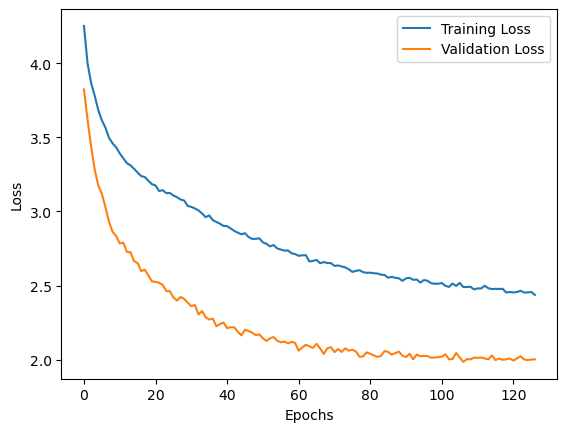

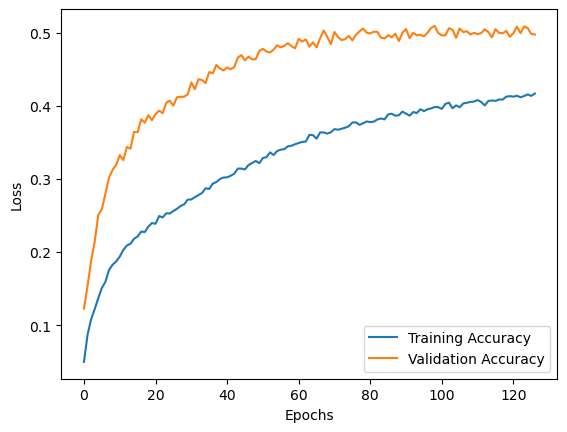

In [188]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [189]:
### Keeping wieght decary 2e-3 

In [192]:
import torchvision.datasets as dsets


## 2c.10 adding data argumentation

In [202]:
# Transformations to see if model can model generalize better
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # flip 
    transforms.RandomRotation(20), # rotates 20 degrees
    transforms.ToTensor(),
])
print(len(train_x))

50000


In [203]:
cifar100_train = dsets.CIFAR100(root='CIFAR100/', train=True, transform=transform, download=True)
cifar100_test = dsets.CIFAR100(root='CIFAR100/', train=False, transform=transforms.ToTensor(), download=True)
subtrain_dataset, validation_dataset = random_split(cifar100_train, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [204]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3)

In [205]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.4235, Training Accuracy: 0.1925
Epoch 9/200, Validation Loss: 2.8039, Validation Accuracy: 0.3322
Epoch 19/200, Training Loss: 3.1931, Training Accuracy: 0.2409
Epoch 19/200, Validation Loss: 2.4780, Validation Accuracy: 0.4019
Epoch 29/200, Training Loss: 3.0494, Training Accuracy: 0.2697
Epoch 29/200, Validation Loss: 2.2914, Validation Accuracy: 0.4320
Epoch 39/200, Training Loss: 2.9669, Training Accuracy: 0.2891
Epoch 39/200, Validation Loss: 2.1747, Validation Accuracy: 0.4706
Epoch 49/200, Training Loss: 2.8950, Training Accuracy: 0.3078
Epoch 49/200, Validation Loss: 2.0968, Validation Accuracy: 0.4851
Epoch 59/200, Training Loss: 2.8450, Training Accuracy: 0.3193
Epoch 59/200, Validation Loss: 2.0462, Validation Accuracy: 0.4947
Epoch 69/200, Training Loss: 2.7996, Training Accuracy: 0.3314
Epoch 69/200, Validation Loss: 1.9962, Validation Accuracy: 0.5066
Epoch 79/200, Training Loss: 2.7628, Training Accuracy: 0.3382
Epoch 79/200, Validation Loss

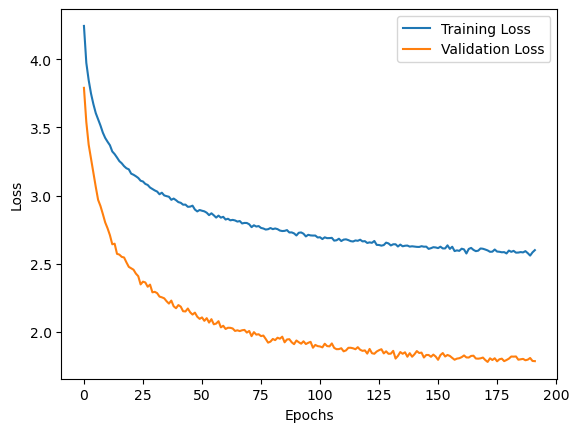

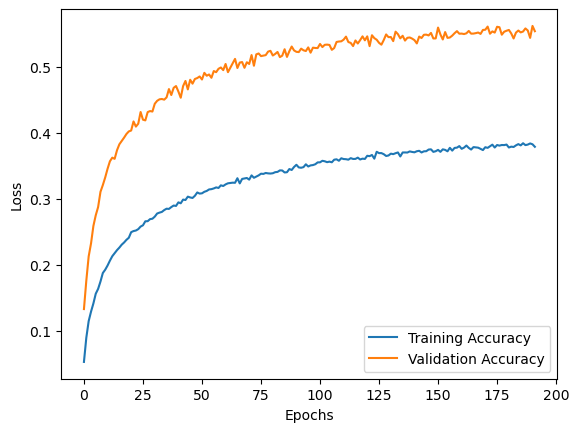

In [206]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [207]:
# Data agumentation has greatly increase the issue going to revert

## 2c.11 Adjusting the lr

In [235]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), 

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.ReLU(),
            nn.Dropout2d(0.2),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
          # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100) 
 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [215]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=2e-4,weight_decay=2e-3) #1e-4->2e-4

In [216]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.2783, Training Accuracy: 0.2283
Epoch 9/200, Validation Loss: 2.6418, Validation Accuracy: 0.3840
Epoch 19/200, Training Loss: 2.9355, Training Accuracy: 0.3035
Epoch 19/200, Validation Loss: 2.2515, Validation Accuracy: 0.4573
Epoch 29/200, Training Loss: 2.7083, Training Accuracy: 0.3581
Epoch 29/200, Validation Loss: 2.0286, Validation Accuracy: 0.5032
Epoch 39/200, Training Loss: 2.5093, Training Accuracy: 0.4102
Epoch 39/200, Validation Loss: 1.9678, Validation Accuracy: 0.5211
Epoch 49/200, Training Loss: 2.4025, Training Accuracy: 0.4359
Epoch 49/200, Validation Loss: 1.9224, Validation Accuracy: 0.5212
Epoch 59/200, Training Loss: 2.3186, Training Accuracy: 0.4577
Epoch 59/200, Validation Loss: 1.9400, Validation Accuracy: 0.5158
Epoch 69/200, Training Loss: 2.2636, Training Accuracy: 0.4753
Early stopping on epoch 69/200
Training Completed


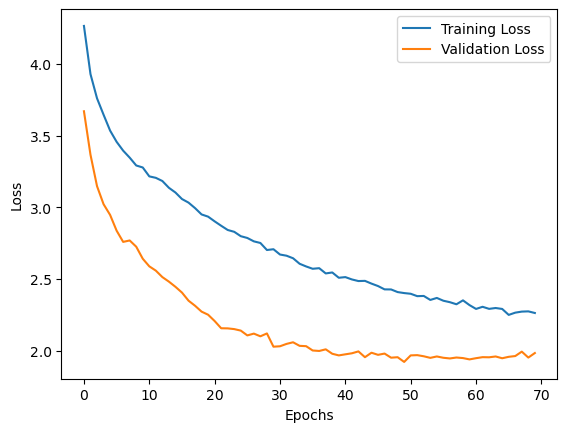

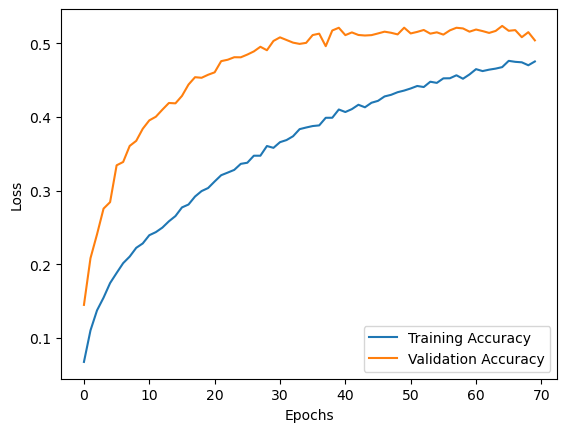

In [217]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [218]:
test_model(model, test_loader)

Test Accuracy: 52.0400%


In [ ]:
# improvement 

In [219]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=2e-4,weight_decay=1e-3) #2e-4->1e-3

In [220]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.1769, Training Accuracy: 0.2466
Epoch 9/200, Validation Loss: 2.4984, Validation Accuracy: 0.4000
Epoch 19/200, Training Loss: 2.7798, Training Accuracy: 0.3367
Epoch 19/200, Validation Loss: 2.1281, Validation Accuracy: 0.4731
Epoch 29/200, Training Loss: 2.4863, Training Accuracy: 0.4100
Epoch 29/200, Validation Loss: 1.9568, Validation Accuracy: 0.5074
Epoch 39/200, Training Loss: 2.2833, Training Accuracy: 0.4639
Epoch 39/200, Validation Loss: 1.9256, Validation Accuracy: 0.5096
Epoch 49/200, Training Loss: 2.1292, Training Accuracy: 0.5053
Epoch 49/200, Validation Loss: 1.9369, Validation Accuracy: 0.5095
Epoch 59/200, Training Loss: 2.0701, Training Accuracy: 0.5256
Epoch 59/200, Validation Loss: 1.9351, Validation Accuracy: 0.5130
Early stopping on epoch 60/200
Training Completed


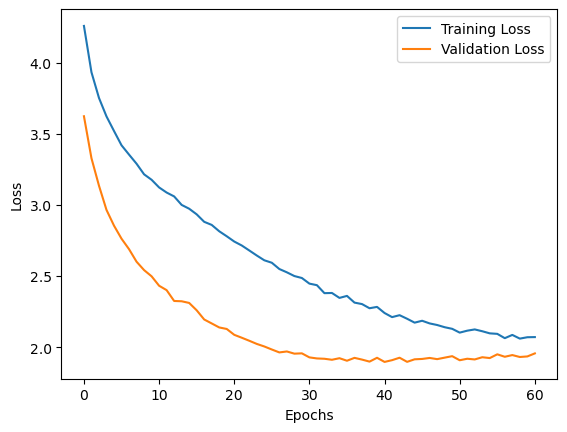

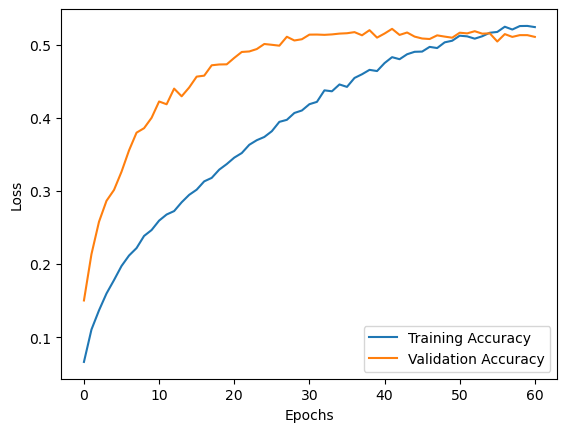

In [221]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# more improvment

In [222]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=2e-4,weight_decay=1e-3,betas=(0.85, 0.999)) # betas added

In [223]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.1739, Training Accuracy: 0.2476
Epoch 9/200, Validation Loss: 2.5154, Validation Accuracy: 0.4012
Epoch 19/200, Training Loss: 2.7946, Training Accuracy: 0.3352
Epoch 19/200, Validation Loss: 2.1329, Validation Accuracy: 0.4768
Epoch 29/200, Training Loss: 2.4957, Training Accuracy: 0.4070
Epoch 29/200, Validation Loss: 1.9629, Validation Accuracy: 0.5053
Epoch 39/200, Training Loss: 2.3004, Training Accuracy: 0.4603
Epoch 39/200, Validation Loss: 1.9228, Validation Accuracy: 0.5048
Epoch 49/200, Training Loss: 2.1668, Training Accuracy: 0.4957
Epoch 49/200, Validation Loss: 1.9327, Validation Accuracy: 0.5067
Early stopping on epoch 57/200
Training Completed


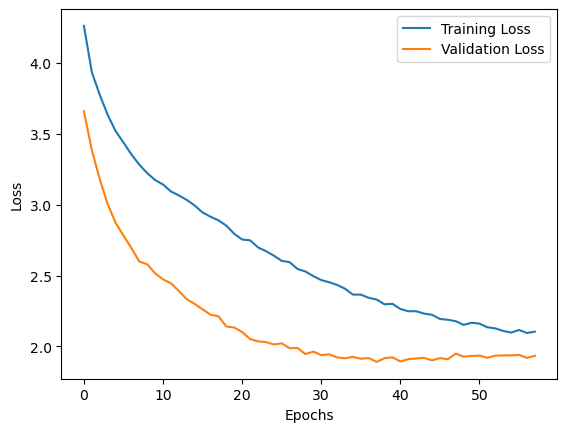

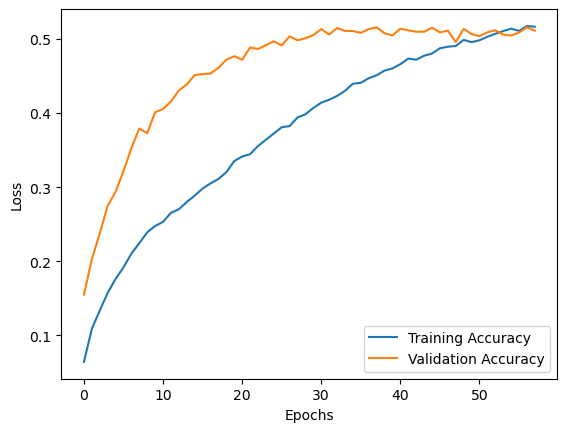

In [224]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [230]:
test_model(model, test_loader)

Test Accuracy: 52.6100%


In [282]:
# imrpovment

In [231]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=2e-4,weight_decay=3e-3,betas=(0.85, 0.999) #1e-3->3e-3


In [232]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.8319, Training Accuracy: 0.1268
Epoch 9/200, Validation Loss: 3.3916, Validation Accuracy: 0.2876
Epoch 19/200, Training Loss: 3.6175, Training Accuracy: 0.1721
Epoch 19/200, Validation Loss: 2.9290, Validation Accuracy: 0.3770
Epoch 29/200, Training Loss: 3.4758, Training Accuracy: 0.2034
Epoch 29/200, Validation Loss: 2.7402, Validation Accuracy: 0.4364
Epoch 39/200, Training Loss: 3.4007, Training Accuracy: 0.2220
Epoch 39/200, Validation Loss: 2.6200, Validation Accuracy: 0.4556
Epoch 49/200, Training Loss: 3.3534, Training Accuracy: 0.2340
Epoch 49/200, Validation Loss: 2.4962, Validation Accuracy: 0.4773
Epoch 59/200, Training Loss: 3.2992, Training Accuracy: 0.2466
Epoch 59/200, Validation Loss: 2.4854, Validation Accuracy: 0.4795
Epoch 69/200, Training Loss: 3.2738, Training Accuracy: 0.2537
Epoch 69/200, Validation Loss: 2.4435, Validation Accuracy: 0.4958
Epoch 79/200, Training Loss: 3.2481, Training Accuracy: 0.2577
Epoch 79/200, Validation Loss

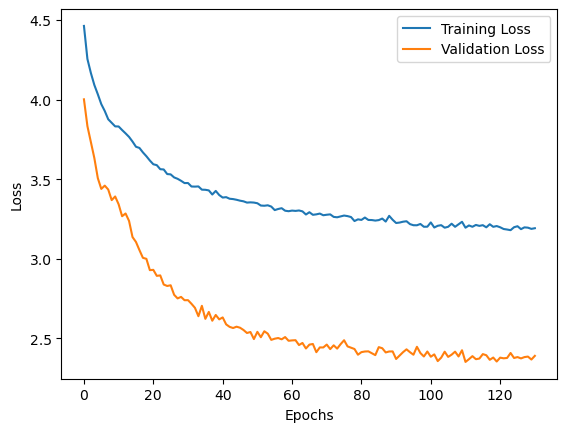

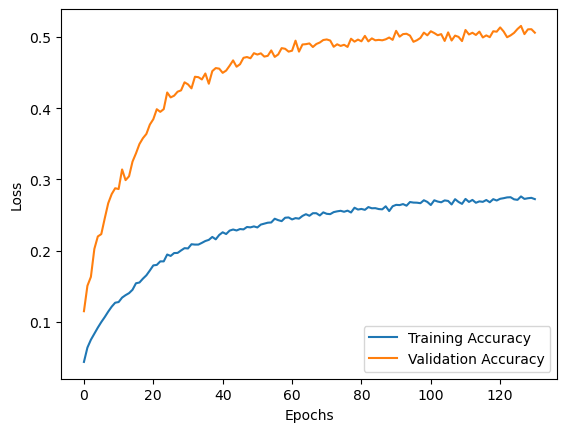

In [234]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [241]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=2e-4,weight_decay=2e-3,betas=(0.85, 0.999))


In [242]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.2813, Training Accuracy: 0.2263
Epoch 9/200, Validation Loss: 2.6646, Validation Accuracy: 0.3723
Epoch 19/200, Training Loss: 2.9223, Training Accuracy: 0.3080
Epoch 19/200, Validation Loss: 2.2625, Validation Accuracy: 0.4540
Epoch 29/200, Training Loss: 2.6858, Training Accuracy: 0.3628
Epoch 29/200, Validation Loss: 2.0719, Validation Accuracy: 0.4900
Epoch 39/200, Training Loss: 2.5427, Training Accuracy: 0.3998
Epoch 39/200, Validation Loss: 1.9820, Validation Accuracy: 0.5098
Epoch 49/200, Training Loss: 2.4048, Training Accuracy: 0.4345
Epoch 49/200, Validation Loss: 1.9608, Validation Accuracy: 0.5145
Epoch 59/200, Training Loss: 2.3254, Training Accuracy: 0.4578
Epoch 59/200, Validation Loss: 1.9637, Validation Accuracy: 0.5103
Epoch 69/200, Training Loss: 2.2668, Training Accuracy: 0.4729
Epoch 69/200, Validation Loss: 1.9786, Validation Accuracy: 0.5087
Early stopping on epoch 72/200
Training Completed


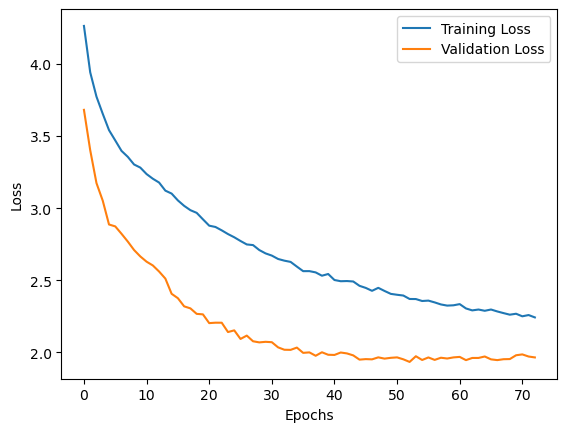

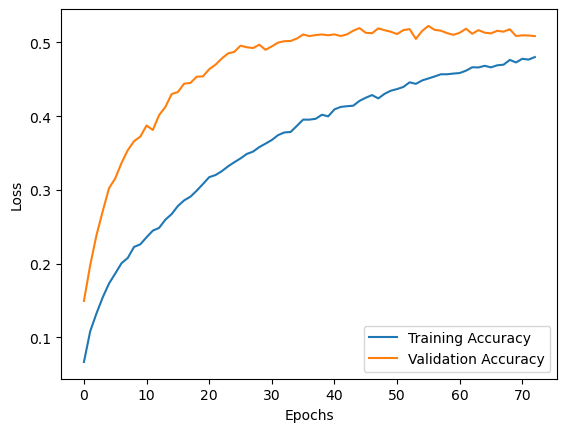

In [243]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


# 2c.12 Best model '2' AlexNet modified

In [244]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3,betas=(0.85, 0.999)) #lr 2e-4-> lr 1e-4


In [245]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.1005, Training Accuracy: 0.2655
Epoch 9/200, Validation Loss: 2.4863, Validation Accuracy: 0.4037
Epoch 19/200, Training Loss: 2.7747, Training Accuracy: 0.3448
Epoch 19/200, Validation Loss: 2.2416, Validation Accuracy: 0.4742
Epoch 29/200, Training Loss: 2.4732, Training Accuracy: 0.4206
Epoch 29/200, Validation Loss: 2.0600, Validation Accuracy: 0.4966
Epoch 39/200, Training Loss: 2.2201, Training Accuracy: 0.4881
Epoch 39/200, Validation Loss: 2.0205, Validation Accuracy: 0.4980
Epoch 49/200, Training Loss: 2.0875, Training Accuracy: 0.5299
Epoch 49/200, Validation Loss: 2.0496, Validation Accuracy: 0.5021
Epoch 59/200, Training Loss: 2.0141, Training Accuracy: 0.5519
Epoch 59/200, Validation Loss: 2.0711, Validation Accuracy: 0.4999
Early stopping on epoch 60/200
Training Completed


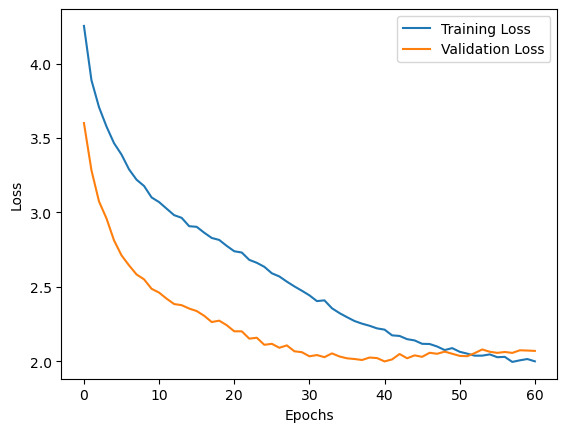

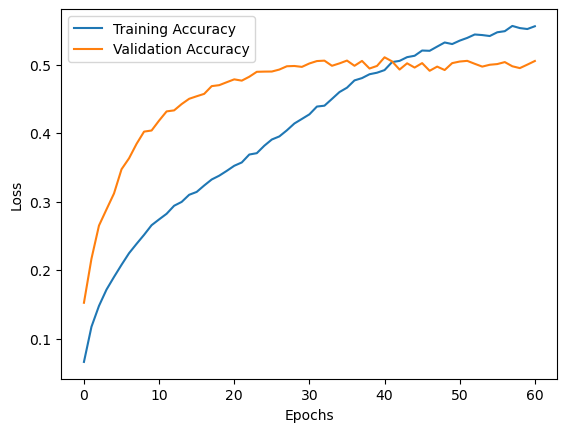

In [246]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [247]:
test_model(model, test_loader)

Test Accuracy: 51.2000%


In [ ]:
# convergence is good and model seem improving

In [249]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=3e-3,betas=(0.85, 0.999))


In [250]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.1339, Training Accuracy: 0.2612
Epoch 9/200, Validation Loss: 2.5243, Validation Accuracy: 0.4055
Epoch 19/200, Training Loss: 2.8717, Training Accuracy: 0.3262
Epoch 19/200, Validation Loss: 2.2990, Validation Accuracy: 0.4693
Epoch 29/200, Training Loss: 2.6264, Training Accuracy: 0.3866
Epoch 29/200, Validation Loss: 2.0805, Validation Accuracy: 0.4972
Epoch 39/200, Training Loss: 2.3750, Training Accuracy: 0.4505
Epoch 39/200, Validation Loss: 2.0280, Validation Accuracy: 0.5110
Epoch 49/200, Training Loss: 2.2182, Training Accuracy: 0.4968
Epoch 49/200, Validation Loss: 2.0294, Validation Accuracy: 0.5122
Epoch 59/200, Training Loss: 2.1179, Training Accuracy: 0.5258
Epoch 59/200, Validation Loss: 2.0652, Validation Accuracy: 0.5077
Early stopping on epoch 68/200
Training Completed


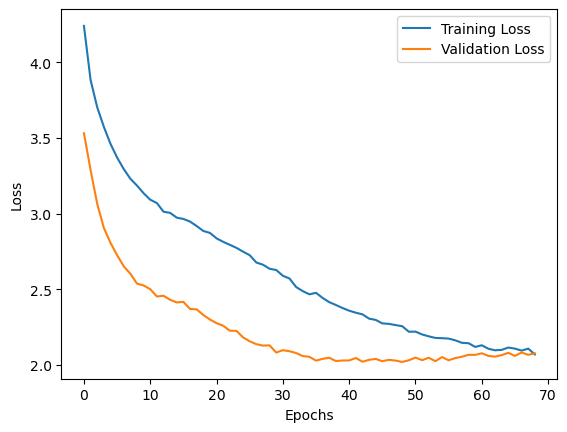

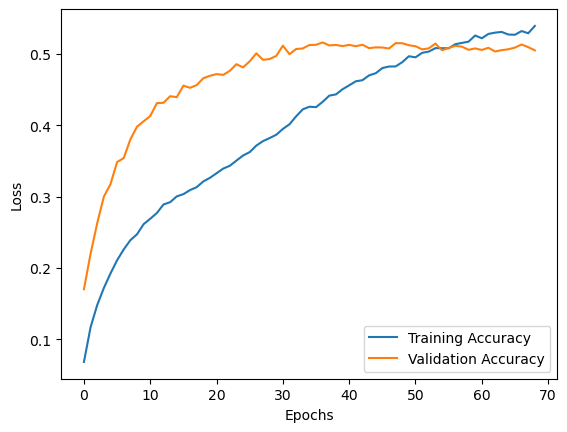

In [251]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [253]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), 

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.ReLU(),
            nn.Dropout2d(0.2),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
          # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.LeakyReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100) 
 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [254]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3,betas=(0.85, 0.999))


In [255]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.2301, Training Accuracy: 0.2402
Epoch 9/200, Validation Loss: 2.4575, Validation Accuracy: 0.3779
Epoch 19/200, Training Loss: 2.9180, Training Accuracy: 0.3078
Epoch 19/200, Validation Loss: 2.2580, Validation Accuracy: 0.4569
Epoch 29/200, Training Loss: 2.6755, Training Accuracy: 0.3665
Epoch 29/200, Validation Loss: 2.1246, Validation Accuracy: 0.4817
Epoch 39/200, Training Loss: 2.4487, Training Accuracy: 0.4196
Epoch 39/200, Validation Loss: 2.0019, Validation Accuracy: 0.4934
Epoch 49/200, Training Loss: 2.2753, Training Accuracy: 0.4654
Epoch 49/200, Validation Loss: 1.9984, Validation Accuracy: 0.4966
Epoch 59/200, Training Loss: 2.1562, Training Accuracy: 0.5004
Epoch 59/200, Validation Loss: 2.0050, Validation Accuracy: 0.4931
Epoch 69/200, Training Loss: 2.0709, Training Accuracy: 0.5292
Epoch 69/200, Validation Loss: 2.0064, Validation Accuracy: 0.4941
Early stopping on epoch 75/200
Training Completed


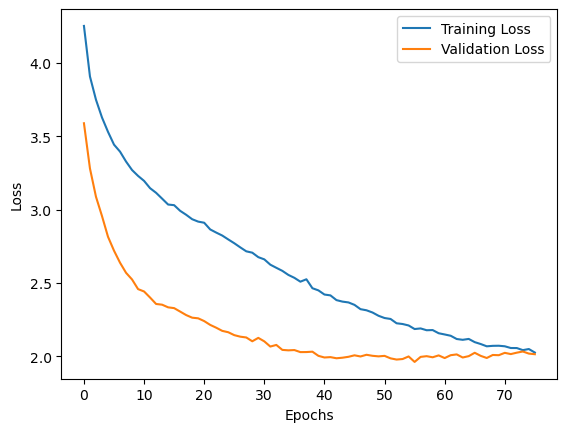

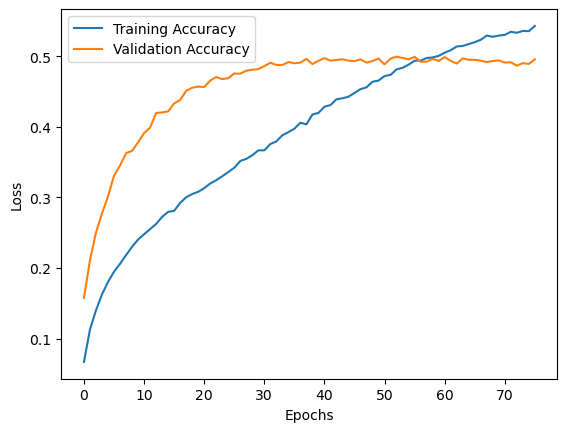

In [256]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [258]:
test_model(model, test_loader)

Test Accuracy: 50.1500%


In [264]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), 

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.ReLU(),
            nn.Dropout2d(0.2),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
          # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.LeakyReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100) 
 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [265]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3,betas=(0.85, 0.999))


In [266]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/200, Training Loss: 3.2341, Training Accuracy: 0.2363
Epoch 9/200, Validation Loss: 2.4464, Validation Accuracy: 0.3839
Epoch 19/200, Training Loss: 2.9154, Training Accuracy: 0.3096
Epoch 19/200, Validation Loss: 2.2443, Validation Accuracy: 0.4592
Epoch 29/200, Training Loss: 2.6634, Training Accuracy: 0.3666
Epoch 29/200, Validation Loss: 2.0971, Validation Accuracy: 0.4767
Epoch 39/200, Training Loss: 2.4521, Training Accuracy: 0.4214
Epoch 39/200, Validation Loss: 1.9974, Validation Accuracy: 0.4993
Epoch 49/200, Training Loss: 2.2978, Training Accuracy: 0.4629
Epoch 49/200, Validation Loss: 1.9854, Validation Accuracy: 0.4998
Epoch 59/200, Training Loss: 2.1545, Training Accuracy: 0.5036
Epoch 59/200, Validation Loss: 1.9877, Validation Accuracy: 0.4979
Epoch 69/200, Training Loss: 2.0816, Training Accuracy: 0.5263
Epoch 69/200, Validation Loss: 2.0006, Validation Accuracy: 0.4936
Epoch 79/200, Training Loss: 2.0099, Training Accuracy: 0.5488
Epoch 79/200, Validation Loss

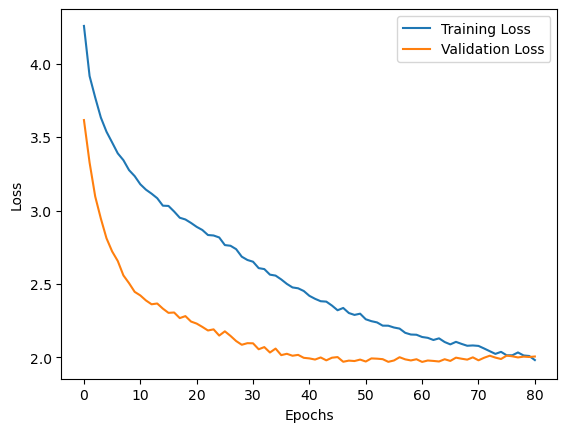

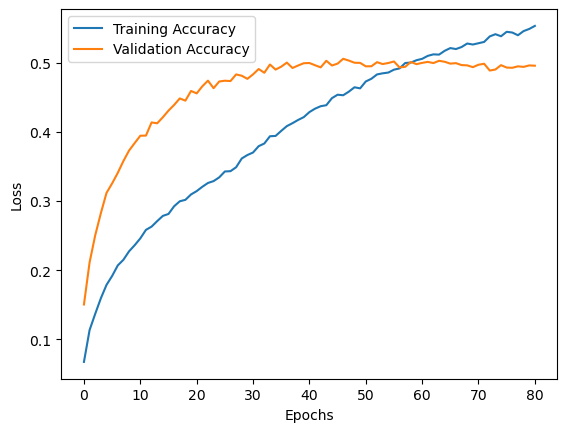

In [267]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [283]:
# using a alex modified alex 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2), # .3 -> .2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32/2 = 16
        )
        # Output size:  16x16x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            # ((16 − 3 + 2(0))/1)+1=   16x16x192
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 16/2 = 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            # ((16 − 5 + 2(0))/1)+1=   16x16x384
            nn.ReLU(),
            nn.Dropout2d(0.3), 

        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.ReLU(),
            nn.Dropout2d(0.2),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
          # ((16 − 5 + 2(0))/1)+1=    16x16  256
            nn.LeakyReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.Dropout1d(0.2),
            nn.ELU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=4096, out_features=100) 
 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [284]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-4,weight_decay=2e-3,betas=(0.85, 0.999))


In [285]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, 32, num_epochs)

Epoch 9/200, Training Loss: 3.2859, Training Accuracy: 0.2266
Epoch 9/200, Validation Loss: 2.5951, Validation Accuracy: 0.3736
Epoch 19/200, Training Loss: 2.9331, Training Accuracy: 0.3052
Epoch 19/200, Validation Loss: 2.2547, Validation Accuracy: 0.4548
Epoch 29/200, Training Loss: 2.6678, Training Accuracy: 0.3665
Epoch 29/200, Validation Loss: 2.0845, Validation Accuracy: 0.4859
Epoch 39/200, Training Loss: 2.4762, Training Accuracy: 0.4129
Epoch 39/200, Validation Loss: 2.0006, Validation Accuracy: 0.4960
Epoch 49/200, Training Loss: 2.3371, Training Accuracy: 0.4520
Epoch 49/200, Validation Loss: 1.9787, Validation Accuracy: 0.4990
Epoch 59/200, Training Loss: 2.2079, Training Accuracy: 0.4854
Epoch 59/200, Validation Loss: 1.9767, Validation Accuracy: 0.5016
Epoch 69/200, Training Loss: 2.1473, Training Accuracy: 0.5054
Epoch 69/200, Validation Loss: 1.9998, Validation Accuracy: 0.4923
Early stopping on epoch 71/200
Training Completed


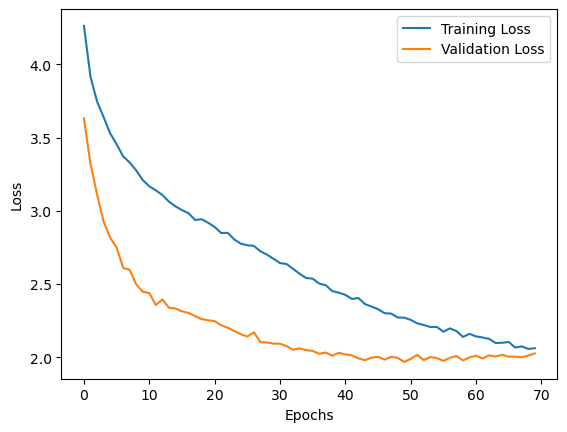

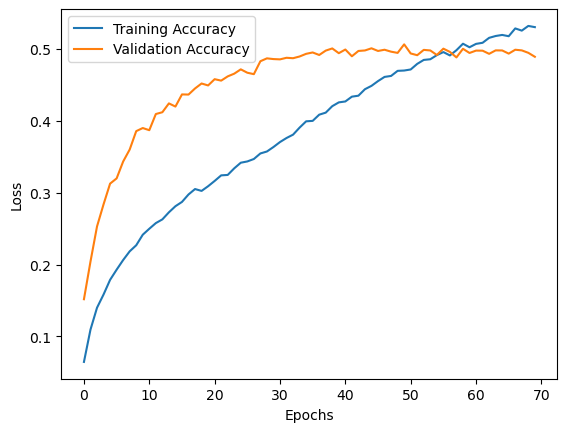

In [274]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)


In [275]:
test_model(model, test_loader)

Test Accuracy: 51.1300%
